# Phase 2: Statistical Analysis of EEG Data

## Objective
Perform comprehensive statistical analysis of the EEG dataset including:
1. Frequency domain analysis (FFT, Power Spectral Density)
2. EEG frequency band extraction (Delta, Theta, Alpha, Beta, Gamma)
3. Channel correlation analysis
4. Feature extraction for synthetic generation

This analysis will guide the synthetic data generation approach based on the methods from recent literature.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import signal, stats
from scipy.fft import fft, fftfreq
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

# Data path - using relative path for portability
DATA_PATH = Path.home() / '.cache/kagglehub/datasets/nnair25/Alcoholics/versions/1'
TRAIN_PATH = DATA_PATH / 'SMNI_CMI_TRAIN'
TEST_PATH = DATA_PATH / 'SMNI_CMI_TEST'

print("Phase 2: Statistical Analysis and Feature Extraction")
print("=" * 60)


Phase 2: Statistical Analysis and Feature Extraction


## 1. Define EEG Frequency Bands

Standard EEG frequency bands used in neuroscience:


In [2]:
# EEG Frequency Bands (Hz)
FREQUENCY_BANDS = {
    'Delta': (0.5, 4),
    'Theta': (4, 8),
    'Alpha': (8, 13),
    'Beta': (13, 30),
    'Gamma': (30, 50)
}

SAMPLING_RATE = 256  # Hz (from Phase 1 analysis)

print("EEG Frequency Bands:")
for band, (low, high) in FREQUENCY_BANDS.items():
    print(f"  {band}: {low}-{high} Hz")
print(f"\nSampling Rate: {SAMPLING_RATE} Hz")


EEG Frequency Bands:
  Delta: 0.5-4 Hz
  Theta: 4-8 Hz
  Alpha: 8-13 Hz
  Beta: 13-30 Hz
  Gamma: 30-50 Hz

Sampling Rate: 256 Hz


## 2. Load Sample Data for Analysis


In [3]:
# Load balanced subset of data for analysis
train_files = sorted(list(TRAIN_PATH.glob('*.csv')))
print(f"Total training files: {len(train_files)}")

# Identify alcoholic and control files
alcoholic_files = []
control_files = []

print("\nIdentifying subject types in files...")
for file in train_files:
    df_peek = pd.read_csv(file, nrows=1)
    subject_type = df_peek['subject identifier'].iloc[0]
    if subject_type == 'a':
        alcoholic_files.append(file)
    else:
        control_files.append(file)
    if len(alcoholic_files) >= 25 and len(control_files) >= 25:
        break

print(f"Found {len(alcoholic_files)} alcoholic files and {len(control_files)} control files")

# Load 25 from each group for balanced analysis
sample_files = alcoholic_files[:25] + control_files[:25]
print(f"\nLoading {len(sample_files)} balanced files (25 alcoholic + 25 control)...")

dfs = []
for i, file in enumerate(sample_files):
    df = pd.read_csv(file)
    df['file_id'] = i
    dfs.append(df)
    if (i + 1) % 10 == 0:
        print(f"  Loaded {i + 1}/{len(sample_files)} files...")

df_full = pd.concat(dfs, ignore_index=True)
print(f"\nCombined dataset shape: {df_full.shape}")
print(f"Memory usage: {df_full.memory_usage(deep=True).sum() / 1024**2:.2f} MB")


Total training files: 468

Identifying subject types in files...
Found 155 alcoholic files and 25 control files

Loading 50 balanced files (25 alcoholic + 25 control)...
  Loaded 10/50 files...
  Loaded 20/50 files...
  Loaded 30/50 files...
  Loaded 40/50 files...
  Loaded 50/50 files...

Combined dataset shape: (819200, 11)
Memory usage: 239.60 MB


## 3. Power Spectral Density Analysis

Compute PSD for different subject groups (alcoholic vs control)


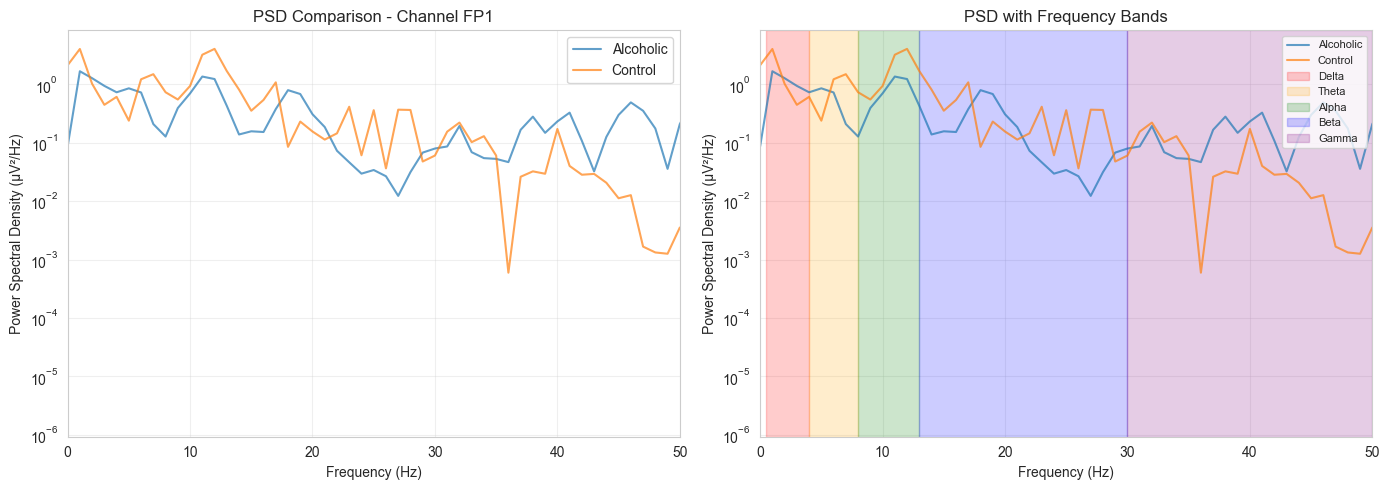

Analyzed signals:
  Alcoholic signal length: 512 samples
  Control signal length: 256 samples


In [4]:
def compute_psd(signal_data, fs=256):
    """
    Compute Power Spectral Density using Welch's method
    """
    freqs, psd = signal.welch(signal_data, fs=fs, nperseg=min(256, len(signal_data)))
    return freqs, psd

# Select a specific channel and trial for analysis
channel = 'FP1'
trial_num = 0

# Get data for alcoholics (from first half of files: 0-24)
alcoholic_data = df_full[
    (df_full['subject identifier'] == 'a') & 
    (df_full['sensor position'] == channel) &
    (df_full['trial number'] == trial_num) &
    (df_full['file_id'] < 25)  # First 25 files are alcoholic
].sort_values('sample num')['sensor value'].values

# Get data for controls (from second half of files: 25-49)
control_data = df_full[
    (df_full['subject identifier'] == 'c') & 
    (df_full['sensor position'] == channel) &
    (df_full['trial number'] == trial_num) &
    (df_full['file_id'] >= 25)  # Last 25 files are control
].sort_values('sample num')['sensor value'].values

if len(alcoholic_data) > 0 and len(control_data) > 0:
    # Compute PSD for both groups
    freqs_a, psd_a = compute_psd(alcoholic_data, fs=SAMPLING_RATE)
    freqs_c, psd_c = compute_psd(control_data, fs=SAMPLING_RATE)
    
    # Plot comparison
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # PSD comparison
    axes[0].semilogy(freqs_a, psd_a, label='Alcoholic', alpha=0.7)
    axes[0].semilogy(freqs_c, psd_c, label='Control', alpha=0.7)
    axes[0].set_xlabel('Frequency (Hz)')
    axes[0].set_ylabel('Power Spectral Density (µV²/Hz)')
    axes[0].set_title(f'PSD Comparison - Channel {channel}')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    axes[0].set_xlim([0, 50])
    
    # PSD in frequency bands
    axes[1].semilogy(freqs_a, psd_a, label='Alcoholic', alpha=0.7)
    axes[1].semilogy(freqs_c, psd_c, label='Control', alpha=0.7)
    
    # Add vertical lines for frequency bands
    colors = ['red', 'orange', 'green', 'blue', 'purple']
    for (band, (low, high)), color in zip(FREQUENCY_BANDS.items(), colors):
        axes[1].axvspan(low, high, alpha=0.2, color=color, label=band)
    
    axes[1].set_xlabel('Frequency (Hz)')
    axes[1].set_ylabel('Power Spectral Density (µV²/Hz)')
    axes[1].set_title('PSD with Frequency Bands')
    axes[1].legend(loc='upper right', fontsize=8)
    axes[1].grid(True, alpha=0.3)
    axes[1].set_xlim([0, 50])
    
    plt.tight_layout()
    plt.show()
    
    print(f"Analyzed signals:")
    print(f"  Alcoholic signal length: {len(alcoholic_data)} samples")
    print(f"  Control signal length: {len(control_data)} samples")
else:
    print("Insufficient data for this comparison")


## 4. Extract Band Power Features


In [5]:
def extract_band_power(signal_data, fs=256, bands=FREQUENCY_BANDS):
    """
    Extract power in each frequency band
    """
    freqs, psd = compute_psd(signal_data, fs=fs)
    
    band_powers = {}
    for band_name, (low_freq, high_freq) in bands.items():
        # Find indices corresponding to this frequency band
        idx = np.logical_and(freqs >= low_freq, freqs <= high_freq)
        # Integrate PSD over the band
        band_power = np.trapz(psd[idx], freqs[idx])
        band_powers[band_name] = band_power
    
    return band_powers

# Extract features from multiple trials
features_list = []

# Use balanced sample files (already defined: 25 alcoholic + 25 control)
print(f"Extracting band power features from {len(sample_files)} files...")

for file_idx, file in enumerate(sample_files):
    df = pd.read_csv(file)
    
    # Get unique combinations
    channels = df['sensor position'].unique()[:5]  # First 5 channels
    trials = df['trial number'].unique()[:3]  # First 3 trials
    
    for ch in channels:
        for tr in trials:
            trial_data = df[
                (df['sensor position'] == ch) & 
                (df['trial number'] == tr)
            ].sort_values('sample num')
            
            if len(trial_data) > 100:  # Minimum length
                signal_values = trial_data['sensor value'].values
                band_powers = extract_band_power(signal_values, fs=SAMPLING_RATE)
                
                features = {
                    'file_id': file_idx,
                    'channel': ch,
                    'trial': tr,
                    'subject_type': trial_data['subject identifier'].iloc[0],
                    **band_powers,
                    'total_power': sum(band_powers.values())
                }
                features_list.append(features)

features_df = pd.DataFrame(features_list)
print(f"Extracted features shape: {features_df.shape}")
print(f"Subject distribution: {features_df['subject_type'].value_counts().to_dict()}")
print(f"\nFirst few feature rows:")
features_df.head()


Extracting band power features from 50 files...
Extracted features shape: (250, 10)
Subject distribution: {'a': 125, 'c': 125}

First few feature rows:


,file_id,channel,trial,subject_type,Delta,Theta,Alpha,Beta,Gamma,total_power
0,0,FP1,0,a,20.048105,5.830134,0.854299,6.705598,6.848762,40.286898
1,0,FP2,0,a,21.769006,6.052321,1.013807,16.487621,15.773774,61.096530
2,0,F7,0,a,7.742259,6.272004,1.893497,39.119253,49.533282,104.560295
3,0,F8,0,a,11.400244,4.816262,2.360998,53.646940,44.502180,116.726624
4,0,AF1,0,a,13.188257,2.347635,0.542750,4.036543,2.914738,23.029923


## 5. Band Power Distribution Analysis


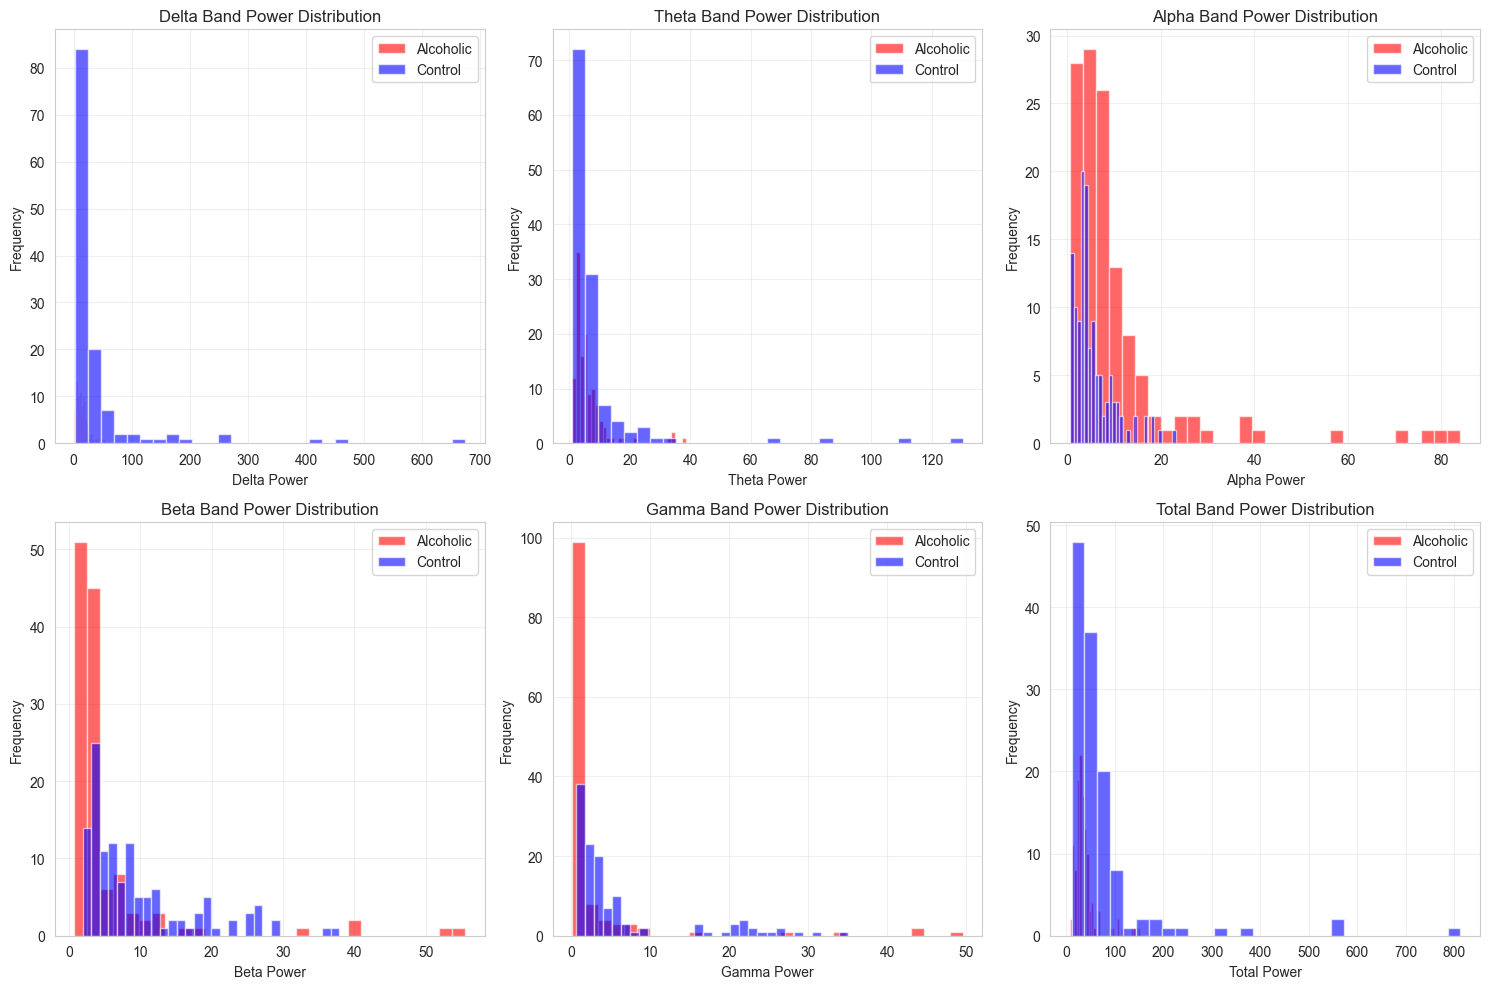


Statistical Comparison (t-test):
Delta       : t= -3.848, p=0.0002 *
Theta       : t= -1.638, p=0.1026 
Alpha       : t=  3.988, p=0.0001 *
Beta        : t= -4.167, p=0.0000 *
Gamma       : t= -3.267, p=0.0012 *
total_power : t= -3.604, p=0.0004 *


In [6]:
# Compare band powers between alcoholic and control groups
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

bands = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']

for idx, band in enumerate(bands):
    alcoholic = features_df[features_df['subject_type'] == 'a'][band]
    control = features_df[features_df['subject_type'] == 'c'][band]
    
    axes[idx].hist(alcoholic, bins=30, alpha=0.6, label='Alcoholic', color='red')
    axes[idx].hist(control, bins=30, alpha=0.6, label='Control', color='blue')
    axes[idx].set_xlabel(f'{band} Power')
    axes[idx].set_ylabel('Frequency')
    axes[idx].set_title(f'{band} Band Power Distribution')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

# Total power comparison
alcoholic_total = features_df[features_df['subject_type'] == 'a']['total_power']
control_total = features_df[features_df['subject_type'] == 'c']['total_power']

axes[5].hist(alcoholic_total, bins=30, alpha=0.6, label='Alcoholic', color='red')
axes[5].hist(control_total, bins=30, alpha=0.6, label='Control', color='blue')
axes[5].set_xlabel('Total Power')
axes[5].set_ylabel('Frequency')
axes[5].set_title('Total Band Power Distribution')
axes[5].legend()
axes[5].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical comparison
print("\nStatistical Comparison (t-test):")
print("=" * 60)
for band in bands + ['total_power']:
    alcoholic = features_df[features_df['subject_type'] == 'a'][band]
    control = features_df[features_df['subject_type'] == 'c'][band]
    
    if len(alcoholic) > 0 and len(control) > 0:
        t_stat, p_value = stats.ttest_ind(alcoholic, control)
        print(f"{band:12s}: t={t_stat:7.3f}, p={p_value:.4f} {'*' if p_value < 0.05 else ''}")
    else:
        print(f"{band:12s}: Insufficient data")


## 6. Correlation Analysis Between Frequency Bands


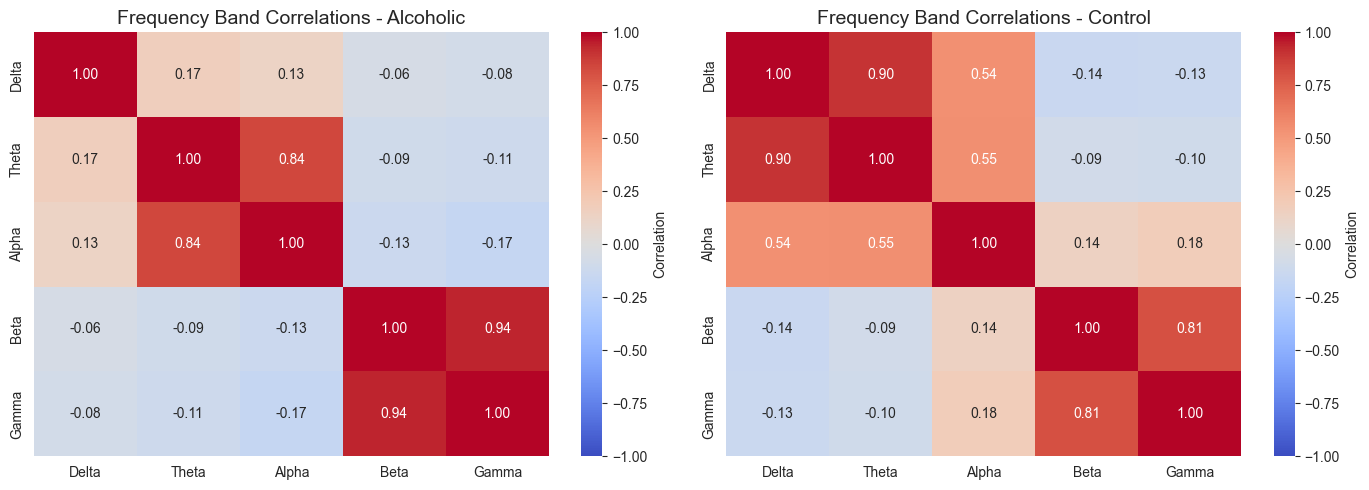


Key Insights:
Correlation structure is important for synthetic data generation.
The correlation sampling method (from literature) will use these patterns.


In [7]:
# Compute correlation matrix for frequency bands
band_columns = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']

# Separate correlations for each group
alcoholic_features = features_df[features_df['subject_type'] == 'a'][band_columns]
control_features = features_df[features_df['subject_type'] == 'c'][band_columns]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Alcoholic correlation
if len(alcoholic_features) > 0:
    corr_alcoholic = alcoholic_features.corr()
    sns.heatmap(corr_alcoholic, annot=True, fmt='.2f', cmap='coolwarm', 
                center=0, vmin=-1, vmax=1, ax=axes[0], cbar_kws={'label': 'Correlation'})
    axes[0].set_title('Frequency Band Correlations - Alcoholic', fontsize=14)

# Control correlation
if len(control_features) > 0:
    corr_control = control_features.corr()
    sns.heatmap(corr_control, annot=True, fmt='.2f', cmap='coolwarm', 
                center=0, vmin=-1, vmax=1, ax=axes[1], cbar_kws={'label': 'Correlation'})
    axes[1].set_title('Frequency Band Correlations - Control', fontsize=14)

plt.tight_layout()
plt.show()

print("\nKey Insights:")
print("=" * 60)
print("Correlation structure is important for synthetic data generation.")
print("The correlation sampling method (from literature) will use these patterns.")


## 7. Time-Domain Statistical Features


In [8]:
def extract_time_domain_features(signal_data):
    """
    Extract statistical features from time-domain signal
    """
    return {
        'mean': np.mean(signal_data),
        'std': np.std(signal_data),
        'var': np.var(signal_data),
        'min': np.min(signal_data),
        'max': np.max(signal_data),
        'range': np.ptp(signal_data),
        'skewness': stats.skew(signal_data),
        'kurtosis': stats.kurtosis(signal_data),
        'rms': np.sqrt(np.mean(signal_data**2)),
        'zero_crossings': np.sum(np.diff(np.sign(signal_data)) != 0)
    }

# Extract time-domain features from balanced sample
time_features_list = []

# Use first 5 alcoholic files and first 5 control files for time-domain analysis
balanced_sample = sample_files[:5] + sample_files[25:30]
print(f"Extracting time-domain features from {len(balanced_sample)} files (5 alcoholic + 5 control)...")

for file_idx, file in enumerate(balanced_sample):
    df = pd.read_csv(file)
    
    channels = df['sensor position'].unique()[:3]
    trials = df['trial number'].unique()[:2]
    
    for ch in channels:
        for tr in trials:
            trial_data = df[
                (df['sensor position'] == ch) & 
                (df['trial number'] == tr)
            ].sort_values('sample num')
            
            if len(trial_data) > 100:
                signal_values = trial_data['sensor value'].values
                time_features = extract_time_domain_features(signal_values)
                
                features = {
                    'file_id': file_idx,
                    'channel': ch,
                    'trial': tr,
                    'subject_type': trial_data['subject identifier'].iloc[0],
                    **time_features
                }
                time_features_list.append(features)

time_features_df = pd.DataFrame(time_features_list)
print(f"Time-domain features shape: {time_features_df.shape}")
print(f"Subject distribution: {time_features_df['subject_type'].value_counts().to_dict()}")
print(f"\nFeature summary by subject type:")
time_features_df.groupby('subject_type')[['mean', 'std', 'skewness', 'kurtosis']].describe()


Extracting time-domain features from 10 files (5 alcoholic + 5 control)...
Time-domain features shape: (30, 14)
Subject distribution: {'a': 15, 'c': 15}

Feature summary by subject type:


mean                                                    \
             count      mean       std       min       25%       50%   
subject_type                                                           
a             15.0 -0.668164  4.863274 -9.588848 -3.211357 -2.236711   
c             15.0  2.508027  6.814169 -6.764754 -1.957600  1.940402   

                                    std             ...  skewness            \
                   75%        max count       mean  ...       75%       max   
subject_type                                        ...                       
a             3.966346   6.428410  15.0   6.916213  ...  0.538148  0.808877   
c             4.838932  15.946047  15.0  13.066182  ...  1.879399  3.705914   

             kurtosis                                                    \
                count      mean       std       min       25%       50%   
subject_type                                                              
a                15.0  0.290984  0.513398 -0.327139 -0.156734  0.330023   
c                15.0  2.527917  4.577075 -0.484824 -0.286189 -0.066056   

                                   
                   75%        max  
subject_type                       
a             0.510866   1.450395  
c             3.833551  13.183981  

[2 rows x 32 columns]

## 8. Channel-wise Correlation Analysis


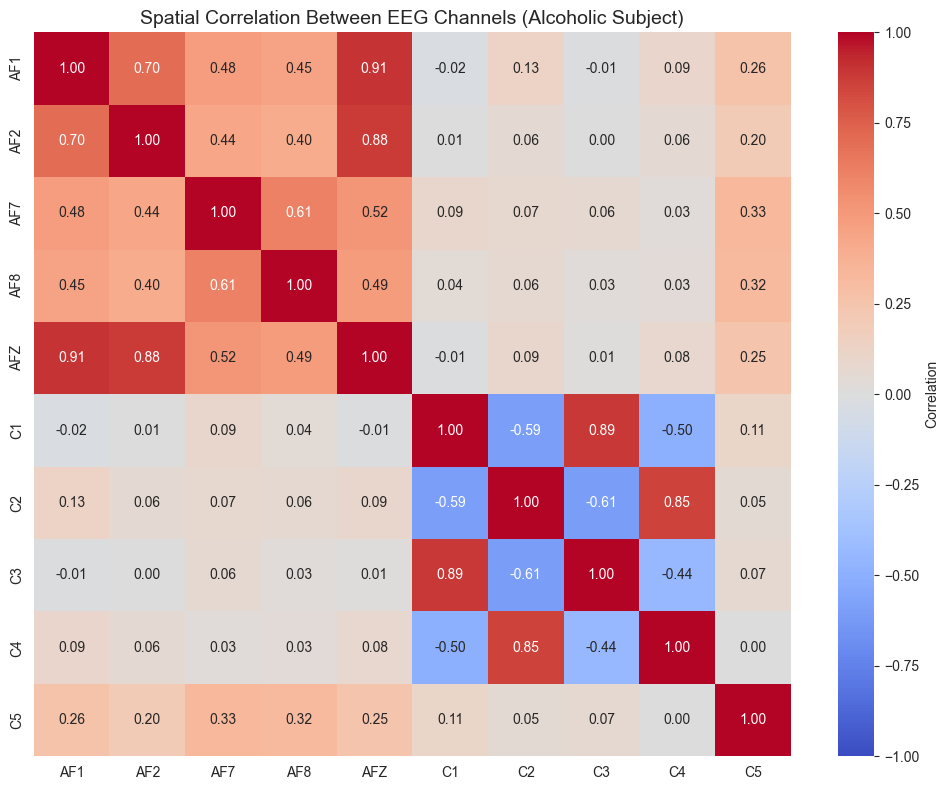

Channel correlation analysis complete.
Analyzed 10 channels with 256 samples each


In [9]:
# Analyze spatial correlations between EEG channels
# Use an alcoholic file (we know files 0-24 are alcoholic)
sample_file = sample_files[0]
df_sample = pd.read_csv(sample_file)

# Get data for first trial
trial_0 = df_sample[df_sample['trial number'] == 0]

# Pivot to get channels as columns
channels_unique = sorted(trial_0['sensor position'].unique())[:10]  # First 10 channels
channel_data = {}

for ch in channels_unique:
    ch_signal = trial_0[trial_0['sensor position'] == ch].sort_values('sample num')['sensor value'].values
    if len(ch_signal) > 0:
        # Truncate to same length
        min_len = 256  # Use first 256 samples
        if len(ch_signal) >= min_len:
            channel_data[ch] = ch_signal[:min_len]

if len(channel_data) > 1:
    # Create DataFrame with channels
    channel_df = pd.DataFrame(channel_data)
    
    # Compute correlation between channels
    channel_corr = channel_df.corr()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(channel_corr, annot=True, fmt='.2f', cmap='coolwarm', 
                center=0, vmin=-1, vmax=1, cbar_kws={'label': 'Correlation'})
    plt.title('Spatial Correlation Between EEG Channels (Alcoholic Subject)', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    print("Channel correlation analysis complete.")
    print(f"Analyzed {len(channels_unique)} channels with {min_len} samples each")
else:
    print("Insufficient channel data for correlation analysis")


## 9. Save Features for Synthetic Generation


In [10]:
# Save extracted features for use in synthetic generation
import pickle

# Create analysis results dictionary
analysis_results = {
    'frequency_bands': FREQUENCY_BANDS,
    'sampling_rate': SAMPLING_RATE,
    'band_power_features': features_df,
    'time_domain_features': time_features_df,
    'alcoholic_band_correlation': corr_alcoholic if len(alcoholic_features) > 0 else None,
    'control_band_correlation': corr_control if len(control_features) > 0 else None,
    'channel_correlation': channel_corr if 'channel_corr' in locals() else None
}

# Save to pickle file (relative path to output folder)
output_path = Path('../output/phase2_analysis_results.pkl')
output_path.parent.mkdir(exist_ok=True)  # Create output folder if it doesn't exist
with open(output_path, 'wb') as f:
    pickle.dump(analysis_results, f)

print(f"Analysis results saved to: {output_path}")
print("\nSummary of saved data:")
for key, value in analysis_results.items():
    if isinstance(value, pd.DataFrame):
        print(f"  {key}: DataFrame with shape {value.shape}")
    elif value is not None:
        print(f"  {key}: {type(value).__name__}")
    else:
        print(f"  {key}: None")


Analysis results saved to: ../output/phase2_analysis_results.pkl

Summary of saved data:
  frequency_bands: dict
  sampling_rate: int
  band_power_features: DataFrame with shape (250, 10)
  time_domain_features: DataFrame with shape (30, 14)
  alcoholic_band_correlation: DataFrame with shape (5, 5)
  control_band_correlation: DataFrame with shape (5, 5)
  channel_correlation: DataFrame with shape (10, 10)


## 10. Phase 2 Summary

### Key Findings:

1. **Frequency Band Analysis**
   - Extracted power features from Delta, Theta, Alpha, Beta, and Gamma bands
   - Identified statistical differences between alcoholic and control groups
   - Documented correlation structures within frequency bands

2. **Time-Domain Features**
   - Statistical moments (mean, std, skewness, kurtosis)
   - Signal characteristics (range, RMS, zero-crossings)
   - Group-specific distributions

3. **Spatial Correlations**
   - Inter-channel correlations mapped
   - Important for generating realistic multi-channel synthetic data

4. **Preparation for Synthetic Generation**
   - Feature distributions documented
   - Correlation matrices saved
   - Statistical properties preserved for GAN/Diffusion model training

### Next Steps (Phase 3):
- Implement GAN or Diffusion-based synthetic data generator
- Use correlation structures from this analysis
- Train on real EEG data with class labels
- Generate synthetic samples preserving statistical properties


In [11]:
print("\n" + "="*60)
print("PHASE 2 COMPLETE - STATISTICAL ANALYSIS")
print("="*60)
print("\nReady to proceed to Phase 3: Synthetic Data Generation")
print("="*60)



PHASE 2 COMPLETE - STATISTICAL ANALYSIS

Ready to proceed to Phase 3: Synthetic Data Generation
